# 인물모드 사진 만들기 프로젝트 📸
- 원래 2개의 렌즈가 필요하지만 딥러닝을 통해 하나의 렌즈만으로 비슷하게 흉내를 내보기로 합니다.
- 이미지 세그멘테이션(Image Segmentation)을 통해 이미지에서 배경과 사람을 분리합니다.
- 분리된 배경을 블러 처리 후 사람 이미지와 다시 합하면 아웃포커싱 효과를 낼 수 있습니다.

## 0. 패키지 및 라이브러리 불러오기

In [1]:
! pip install opencv-python pixellib # 다시 시작이 요구될 수 있습니다.

- ```cv2``` : OpenCV 라이브러리로, 실시간 컴퓨터 비전을 목적으로 한 프로그래밍 라이브러리
- ```numpy(NumPy)``` : 행렬이나 대규모 다차원 배열을 쉽게 처리할 수 있도록 지원하는 라이브러리. 데이터 구조 외에도 수치 계산을 위해 효율적으로 구현된 기능을 제공
- ```torch``` : PyTorch. 딥러닝 및 텐서 연산을 위한 라이브러리. 인공지능 모델을 만들거나 불러와 추론하는 도구
- ```torchvision``` : 이미지 변환 및 전처리를 위한 torchvision의 transform 모듈
- ```deeplabv3_resnet101``` : 사전 학습된 DeepLabV3 모델. 이미지를 분류하도록 학습된 모델
- ```matplotlib``` : 파이썬 프로그래밍 언어 및 수학적 확장 NumPy 라이브러리를 활용한 플로팅 라이브러리로, 데이터 시각화 도구

In [2]:
import cv2
import os
import numpy as np
import torch
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet101
import matplotlib.pyplot as plt

## 1. 사진 준비

In [3]:
# 준비한 이미지 파일의 경로를 이용하여, 이미지 파일을 읽음
# cv2.imread(경로) : 경로에 해당하는 이미지 파일을 읽어서 변수에 저장

home_dir = os.getenv('HOME')
img_path = os.path.join(home_dir, "work/0729/human_segmentation_project/Tate_Modern.jpg")
img_orig = cv2.imread(img_path)

print(f"이미지 크기: {img_orig.shape}")

이미지 크기: (1440, 1080, 3)


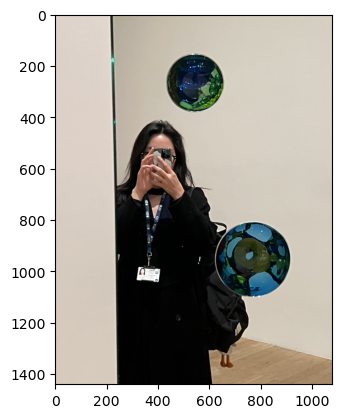

In [4]:
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 이미지 색상 채널을 변경 (BGR 형식을 RGB 형식으로 변경)

# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시, 입력은 RGB(A) 데이터 혹은 2D 스칼라 데이터
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html
# plt.show(): 현재 열려있는 모든 figure를 표시 (여기서 figure는 이미지, 그래프 등)
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.show.html

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

## 2. 시맨틱 세그멘테이션(Segmentation)으로 피사체(사람)와 배경을 분리하기
- 이미지 세그멘테이션 : 모든 픽셀에 라벨을 할당하고, 라벨이 같은 객체들은 공통적인 특징을 가진다고 가정합니다.
- 픽셀이 비슷하게 생긴 것을 인식하지만, 실제 물체 단위로 인식하지 않을 수 있습니다.

- 시멘틱 세그멘테이션 : 실제 세계처럼 물리적 의미 단위로 인식하는 세그멘테이션을 말합니다.
- 인스턴스 세그멘테이션 : 사람을 예시로 들면, 각각의 사람들이 서로 다른 라벨을 가져서 사람끼리 구분할 수 있습니다.

In [5]:
# Torchvision 제공 모델 다운로드
model = deeplabv3_resnet101(pretrained=True).eval()

# 이미지 전처리를 위한 파이프라인 정의
transform = T.Compose([ 
    T.ToPILImage(),        # Numpy 배열 또는 PyTorch 이미지를 PIL 이미지 객체로 변환
    T.Resize((520, 520)),  # 모델 입력 크기 (고정)
    T.ToTensor(),
])

/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


- ```cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)``` : RGB 이미지로 변환합니다.(OpenCV 때문)
- ```transform()``` : 아까 만든 전처리 파이프라인 transform을 적용합니다.
- ```unsqueeze(0)``` : Pytorch 모델은 (B, C, H, W) 형태로 받음. 배치 차원을 추가해주었습니다.

- 결과적으로 ```input_tensor```는 모델에 바로 넣을 수 있는 1장의 전처리된 이미지가 됩니다.

In [6]:
# OpenCV 이미지 -> PyTorch 모델로 넣기 위한 전처리
input_tensor = transform(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)).unsqueeze(0)

In [7]:
# 모델에 이미지를 넣어 봅니다
with torch.no_grad():
    output = model(input_tensor)["out"][0]
    output_predictions = output.argmax(0).byte().cpu().numpy()

# 원본 크기로 Resize
output_predictions_resized = cv2.resize(output_predictions, (img_orig.shape[1], img_orig.shape[0]), interpolation=cv2.INTER_NEAREST)

In [8]:
#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

- person 라벨(= 15번)만 추출하고 싶은데, 아래 실행했더니 바로 된 거 뭐지?
- 알고보니 위에서 ```output_predictions = output.argmax(0).byte().cpu().numpy()```를 사용했습니다.
- 이거는 각 픽셀에 대해 가장 높은 점수를 받은 클래스 인덱스를 추출하는 코드였습니다.

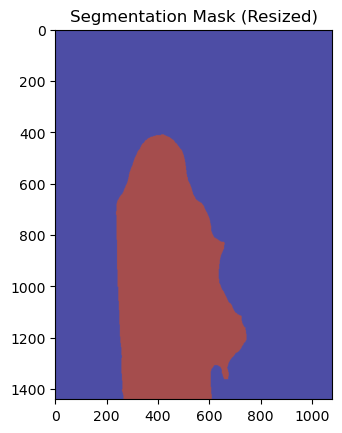

In [9]:
plt.imshow(output_predictions_resized, cmap="jet", alpha=0.7)
plt.title("Segmentation Mask (Resized)")
plt.show()

In [10]:
unique_classes = np.unique(output_predictions_resized)
unique_classes

array([ 0, 15], dtype=uint8)

In [11]:
for class_id in unique_classes:
    print(LABEL_NAMES[class_id])

background
person


- 다른 클래스도 있지 않을까! 했지만 아무래도 단조로운 배경이라 분리되지 않은 것 같습니다.
- 여러가지 물체가 있는 사진으로 다시 한 번 실험을 해봐도 좋을 것 같습니다!

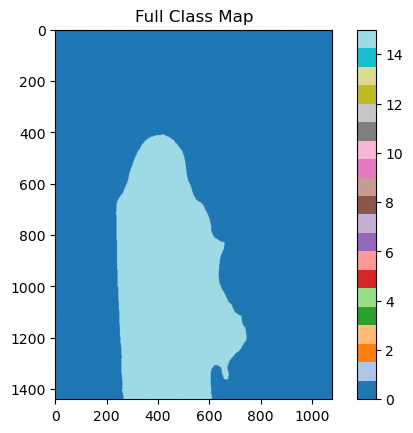

In [12]:
# 모든 클래스 맵을 보고 싶은데... 사진 자체가 인물 + 단조로운 배경이라 구분이 너무 잘 된 것 같습니다..
plt.imshow(output_predictions_resized, cmap="tab20")  # 범주형 색상
plt.title("Full Class Map")
plt.colorbar()
plt.show()

- 아래의 코드는 클래스 인덱스 0~19번에 대해서 시각화용 RGB 색상을 지정한 결과를 의미합니다.
- 각 행은 RGB를 의미합니다. (총 20개!)
- PixelLib의 고유 색상 생성 알고리즘을 이용했는데, 클래스마다 눈에 띄게 다른 색상을 만들도록 설계되어 있습니다.
- 색상 구분이 잘 될 수록 세그멘테이션 마스크를 시각화할 때 유용하다고 합니다.

In [13]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생성 코드 결과물이예요!

#컬러맵 만들기
colormap = np.zeros((256, 3), dtype=int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]  # 생성한 20개의 컬러맵 출력

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [14]:
colormap[15] #컬러맵 15에 해당하는 배열 출력 (pacalvoc에 LABEL_NAMES 15번째인 사람)

array([192, 128, 128])

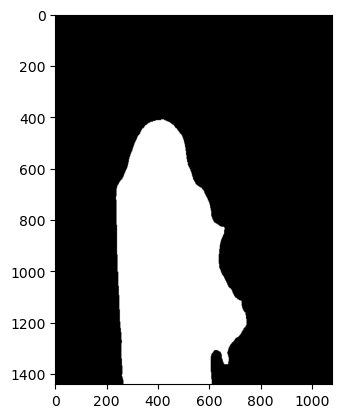

In [15]:
# output의 픽셀 별로 예측된 class가 사람이라면 1(True), 다르다면 0(False)이 됩니다
# 1과 0에 각각 255를 곱하였으므로 사람으로 예측된 픽셀은 255, 그렇지 않은 픽셀은 0
# cmap 값을 변경하면 다른 색상으로 확인이 가능함
seg_map = (output_predictions_resized == 15)  # 클래스 ID 15 (사람)
img_mask = seg_map.astype(np.uint8) * 255  # 255 값으로 변환
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

plt.imshow(img_mask, cmap='gray')  # 흑백으로 표시
plt.show()

- 나름 괜찮게 인물과 백여이 분리된 것을 확인할 수 있었습니다.
- 사진 속 동그라미는 사실 예술 작품입니다. (...)

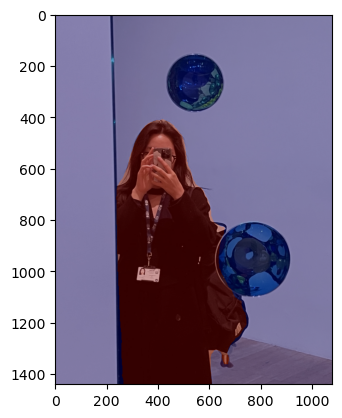

In [16]:
# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.

img_show = cv2.addWeighted(img_orig, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

## 3. 블러링(Blurring) 기술로 배경을 흐리게 하기

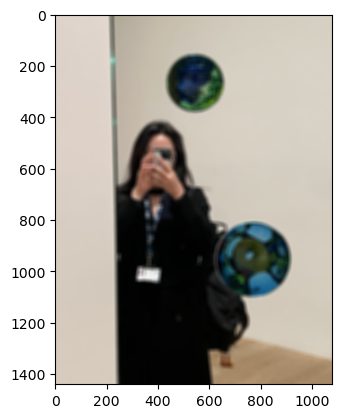

In [17]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (20, 20))

# plt.imshow() : 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드) : 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

- ```bitwise_not``` 함수를 사용하면 이미지가 반전이 됩니다. (원래 마스크에서 배경이 0, 사람이 255)
- 반전된 세그멘테이션 결과를 이용해서 ```bitwise_and``` 연산을 수행하면 배경만 있는 사진을 얻을 수 있습니다.
- 0과 어떤 수를 ```bitwise_and``` 연산해도 0이 되기 때문에, 사람이 0인 경우에는 사람이 있던 픽셀이 모두 0이 됩니다.

| 연산자  | 이름      | 설명                               |                   |
| ---- | ------- | -------------------------------- | ----------------- |
| `&`  | AND     | 두 비트가 모두 1이면 1                   |                   |
| \`   | OR      | 두 비트 중 하나라도 1이면 1              |                   |
| `^`  | XOR     | 두 비트가 서로 다르면 1                   |                   |
| `~`  | NOT     | 비트를 반전 (1 → 0, 0 → 1)            |                   |
| `<<` | 왼쪽 시프트  | 비트를 왼쪽으로 밀기 (`<< n` : 2ⁿ 곱하기 효과)  |                   |
| `>>` | 오른쪽 시프트 | 비트를 오른쪽으로 밀기 (`>> n` : 2ⁿ 나누기 효과) |                   |


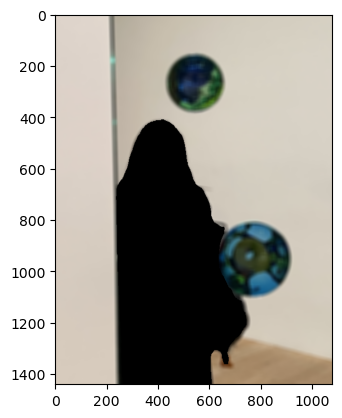

In [18]:
# cv2.cvtColor(입력 이미지, 색상 변환 코드) : 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB : 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not() : 이미지가 반전됩니다. 배경이 0 사람이 255 였으나
# 연산을 하고 나면 배경은 255 사람은 0입니다.
img_bg_mask = cv2.bitwise_not(img_mask_color)

# cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에
# 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

## 4. 피사체를 배경의 원래 위치에 합성하기
- ```img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)``` 이 부분이 가장 중요한 부분입니다.
- 아까 블러 처리한 배경은 그대로 두고, 세그멘테이션 마스크에서 255인 부분만 원본 이미지 값을 가져옵니다.

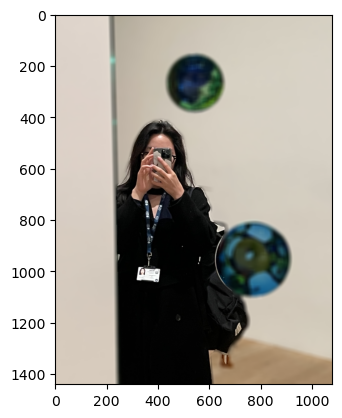

In [19]:
# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고
# 아닌 영역은 블러된 이미지 값을 사용합니다.
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

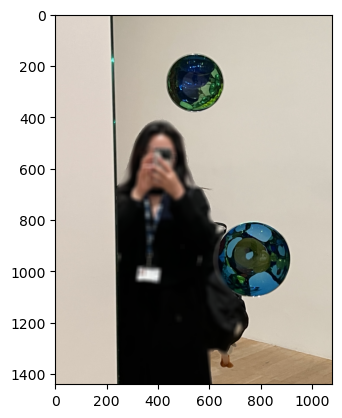

In [20]:
# Q. 이번에는 사람 부분을 블러로, 배경 부분을 원본으로 출력해볼까요?
# 힌트 : img_mask_color 옵션을 적절히 조정해주고, img_orig, img_orig_blur 를 활용하세요.
img_concat = np.where(img_mask_color == 255, img_orig_blur, img_orig) # 순서만 바꿔주면 됩니다!
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 5. 동물 사진에도 아웃 포커싱을 적용하기
- 위의 과정을 함수화하여 이미지를 입력하면 아웃 포커싱을 적용하도록 했습니다.
- 입력 이미지에서 고양이(클래스 8)만 남기고 나머지는 블러 처리한 아웃 포커싱 이미지를 반환합니다.

In [21]:
def apply_outfocus_to_cat(image_bgr: np.ndarray) -> np.ndarray:

    # 전처리 파이프라인 정의
    transform = T.Compose([
        T.ToPILImage(),
        T.Resize((520, 520)),
        T.ToTensor(),
    ])

    # BGR → RGB 변환 후 Tensor로 변환
    img_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    input_tensor = transform(img_rgb).unsqueeze(0)

    # 모델 불러오기
    model = deeplabv3_resnet101(pretrained=True).eval()

    # 모델 예측
    with torch.no_grad():
        output = model(input_tensor)["out"][0]
        prediction = output.argmax(0).byte().cpu().numpy()

    # 마스크 원본 크기로 리사이즈
    mask_resized = cv2.resize(prediction, (image_bgr.shape[1], image_bgr.shape[0]), interpolation=cv2.INTER_NEAREST)

    # 고양이 영역만 마스크 생성 (클래스 8)
    person_mask = (mask_resized == 8).astype(np.uint8) * 255

    # 마스크 컬러 변환 및 반전
    mask_color = cv2.cvtColor(person_mask, cv2.COLOR_GRAY2BGR)
    mask_inv = cv2.bitwise_not(mask_color)

    # 배경 블러
    blurred = cv2.blur(image_bgr, (20, 20))
    background = cv2.bitwise_and(blurred, mask_inv)

    # 고양이 영역은 원본 이미지에서 추출
    result = np.where(mask_color == 255, image_bgr, background)

    return result

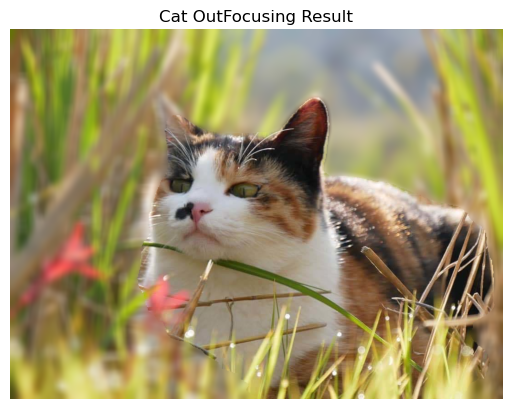

In [22]:
img = cv2.imread("hahaha_samsaek.jpeg")
outfocus_img = apply_outfocus_to_cat(img)

plt.imshow(cv2.cvtColor(outfocus_img, cv2.COLOR_BGR2RGB))
plt.title("Cat OutFocusing Result")
plt.axis("off")
plt.show()

## 6. 피사체 + 배경 전환

In [23]:
# 주요 라이브러리 다시 불러오기
! pip install opencv-python pixellib

import cv2
import numpy as np
import torch
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet101
import matplotlib.pyplot as plt

print(cv2.__version__)

4.11.0


- 고양이 사진과 사막 사진을 가져왔습니다.

원본 고양이 이미지 크기: (810, 1080, 3)
배경(사막) 이미지 크기: (450, 800, 3)


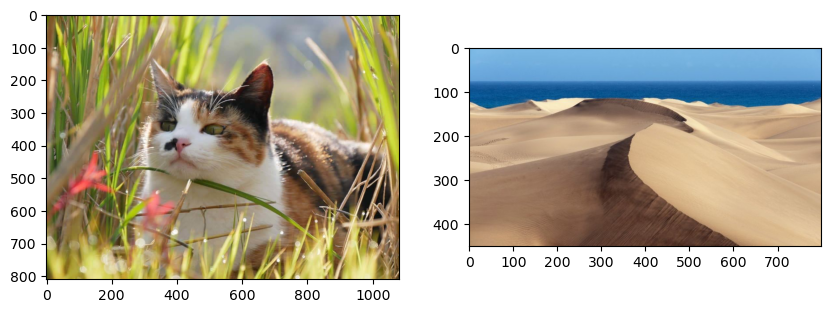

In [24]:
cat_img_path = "hahaha_samsaek.jpeg"  # 고양이 이미지를 준비해주세요
sand_img_path = "desert.jpg"  # 사막 배경 이미지를 준비해주세요

cat_img = cv2.imread(cat_img_path)
sand_img = cv2.imread(sand_img_path)

cat_img = cv2.cvtColor(cat_img, cv2.COLOR_BGR2RGB)
sand_img = cv2.cvtColor(sand_img, cv2.COLOR_BGR2RGB)

print(f"원본 고양이 이미지 크기: {cat_img.shape}")
print(f"배경(사막) 이미지 크기: {sand_img.shape}")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cat_img)

plt.subplot(1, 2, 2)
plt.imshow(sand_img)

plt.show()

In [25]:
# 전처리, 모델에 이미지 입력 등 (기존 그대로)
model = deeplabv3_resnet101(pretrained=True).eval()

transform = T.Compose([
    T.ToPILImage(),
    T.Resize((520, 520)),  # 모델 입력 크기
    T.ToTensor(),
])

input_tensor = transform(cat_img).unsqueeze(0)

with torch.no_grad():
    output = model(input_tensor)["out"][0]
    output_predictions = output.argmax(0).byte().cpu().numpy()

print(f"추론 마스크 크기 (Before Resize): {output_predictions.shape}")

추론 마스크 크기 (Before Resize): (520, 520)


In [26]:
# 마스크를 원본 크기로 Resize
output_predictions_resized = cv2.resize(output_predictions, (cat_img.shape[1], cat_img.shape[0]), interpolation=cv2.INTER_NEAREST)

print(f"추론 마스크 크기 (After Resize): {output_predictions_resized.shape}")

추론 마스크 크기 (After Resize): (810, 1080)


- 위에서는 따로 클래스 번호를 작성했으나, 여기는 예측된 클래스를 이용했습니다.
- 그렇다는 건 함수를 만들 때 ```np.unique```를 사용하면 된다는 이야기가 됩니다. (왜 안 썼지..)
- 이는 어떤 것을 우선 순위로 둘 것이냐에 따라서 .. 고려해야 할 요소가 많기 때문에 더 생각을 해야할 것 같습니다.

In [27]:
unique_classes = np.unique(output_predictions_resized)
print(f"예측된 클래스 ID: {unique_classes}")

예측된 클래스 ID: [0 8]


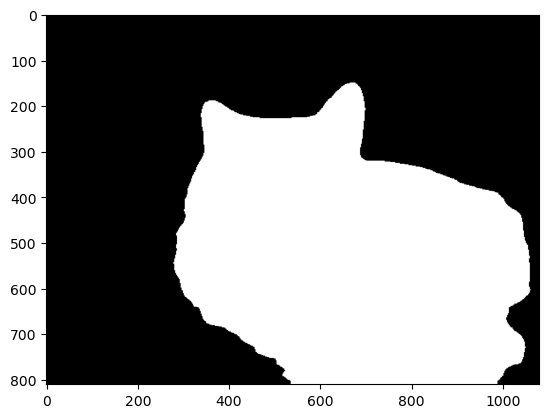

In [28]:
target_class_id = unique_classes[-1]

seg_map = (output_predictions_resized == target_class_id)
img_mask = seg_map.astype(np.uint8) * 255

plt.imshow(img_mask, cmap='gray')
plt.show()

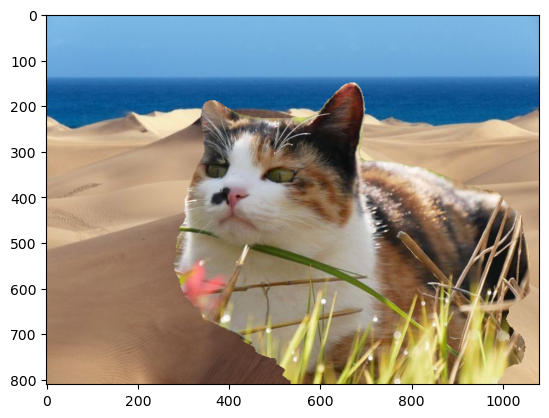

In [29]:
# 배경을 고양이 이미지 크기에 맞춤
sand_img_resized = cv2.resize(sand_img, (cat_img.shape[1], cat_img.shape[0]))

# 고양이 부분만 남기고 배경 적용
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)  # 3채널 변환
result_img = np.where(img_mask_color == 255, cat_img, sand_img_resized)  # 마스크 기반 합성

plt.imshow(result_img)
plt.show()

- 고양이 사진과 사막 배경을 합성했으나, 고양이 사진이 제대로 분리되지 않았다는 문제가 있습니다.
- 풀숲에 있는 고양이 사진이라 고양이의 경계선이 명확히 나뉘지는 않지만 풀-고양이 대비가 확실한 부분이 있긴 합니다.
- 자 그렇다면 이 문제점을 어떻게 해결할 수 있을지 다음 챕터에서 살펴봅시다.

## 7. 인물 모드 사진에서 나타나는 문제점 해결 과정 

- 시맨틱 세그멘테이션이 아무리 정확해도 실제 카메라 렌즈의 아웃포커싱 효과처럼 자연스럽게 물체를 분리하기 어렵습니다.
- 실제 카메라는 거리를 아주 미세하게 구별하여 부드럽고 자연스러운 심도 표현이 가능하기 때문입니다.
- 시멘틱 세그멘테이션은 픽셀 단위로 사물을 구별하기 때문에, 각 픽셀에 대해 클래스에 대한 명확한 경계선을 그립니다.
- 그러므로 항상 어느 정도의 오차나 경계의 부자연스러움이 존재하게 됩니다.

In [30]:
def apply_outfocus_to_human(image_bgr: np.ndarray) -> np.ndarray:

    # 전처리 파이프라인 정의
    transform = T.Compose([
        T.ToPILImage(),
        T.Resize((520, 520)),
        T.ToTensor(),
    ])

    # BGR → RGB 변환 후 Tensor로 변환
    img_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    input_tensor = transform(img_rgb).unsqueeze(0)

    # 모델 불러오기
    model = deeplabv3_resnet101(pretrained=True).eval()

    # 모델 예측
    with torch.no_grad():
        output = model(input_tensor)["out"][0]
        prediction = output.argmax(0).byte().cpu().numpy()

    # 마스크 원본 크기로 리사이즈
    mask_resized = cv2.resize(prediction, (image_bgr.shape[1], image_bgr.shape[0]), interpolation=cv2.INTER_NEAREST)

    # 인물 영역만 마스크 생성 (클래스 15)
    person_mask = (mask_resized == 15).astype(np.uint8) * 255

    # 마스크 컬러 변환 및 반전
    mask_color = cv2.cvtColor(person_mask, cv2.COLOR_GRAY2BGR)
    mask_inv = cv2.bitwise_not(mask_color)

    # 배경 블러
    blurred = cv2.blur(image_bgr, (20, 20))
    background = cv2.bitwise_and(blurred, mask_inv)

    # 인물 영역은 원본 이미지에서 추출
    result = np.where(mask_color == 255, image_bgr, background)

    return result, mask_resized

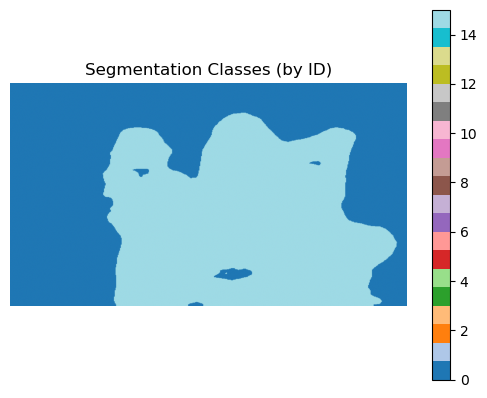

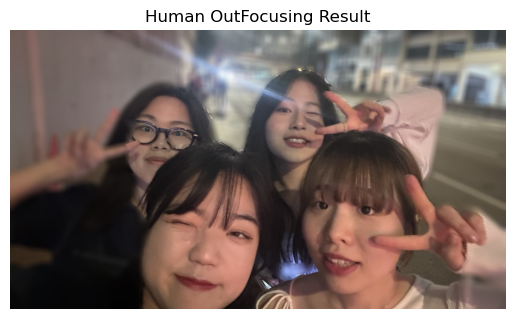

In [31]:
# mask_resized를 같이 반환해서 경계를 확실히 확인하고자 했습니다.
img = cv2.imread("319.jpg")

# 반환값 분리!
outfocus_img, mask_resized = apply_outfocus_to_human(img)

# 클래스 분할 시각화
plt.imshow(mask_resized, cmap='tab20')
plt.colorbar()
plt.title("Segmentation Classes (by ID)")
plt.axis("off")
plt.show()

# 결과 시각화
plt.imshow(cv2.cvtColor(outfocus_img, cv2.COLOR_BGR2RGB))
plt.title("Human OutFocusing Result")
plt.axis("off")
plt.show()

- 그래서 그런지 제 팔과 친구의 어깨가 제대로 인식이 안 된 거 같습니다.
- 얼굴은 어느 정도 살아 남았는데 옷도 그렇고 뭔가 자연스럽지 않습니다.

## 7-1. OpenCV의 morphologyEX를 활용한 마스크 후처리
- 시멘틱 세그멘테이션 결과의 노이즈를 제거하고 경계를 부드럽게 만든다. 

In [32]:
# MORPH_OPEN : 작은 잡음을 제거합니다.
# MORPH_CLOSE : 작은 구멍이나 틈을 메웁니다.

import cv2
import numpy as np
import torch
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet101
from cv2 import morphologyEx, MORPH_OPEN, MORPH_CLOSE, getStructuringElement

- 함수 내용은 위에 작성했던 내용과 대체적으로 비슷합니다.
- 달라진 부분만 추가적으로 설명을 작성해 놓았습니다.

In [33]:
def apply_outfocus_to_human_mor(image_bgr: np.ndarray) -> np.ndarray:
    transform = T.Compose([
        T.ToPILImage(),
        T.Resize((520, 520)),
        T.ToTensor(),
    ])

    # BGR → RGB 변환 후 Tensor로 변환
    img_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    input_tensor = transform(img_rgb).unsqueeze(0)

    # 모델 불러오기
    model = deeplabv3_resnet101(pretrained=True).eval()

    # 예측
    with torch.no_grad():
        output = model(input_tensor)["out"][0]
        prediction = output.argmax(0).byte().cpu().numpy()

    # 원본 크기 복원
    mask_resized = cv2.resize(prediction, (image_bgr.shape[1], image_bgr.shape[0]), interpolation=cv2.INTER_NEAREST)

    # 인물 클래스(15)만 선택
    person_mask = (mask_resized == 15).astype(np.uint8) * 255


    
    # 여기 부분이 상당히 중요 !!!!
    # 잡음을 제거하고 부드럽게 하기 위해서 Morphological Operation(열림 -> 닫힘)을 적용했습니다.
    kernel = getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))  # 커널 크기 조정 가능
    refined_mask = morphologyEx(person_mask, MORPH_OPEN, kernel) # 작은 잡음을 제거하고
    refined_mask = morphologyEx(refined_mask, MORPH_CLOSE, kernel) # 내부의 작은 구멍을 메웁니다.



    
    # 마스크 컬러 변환 및 반전
    mask_color = cv2.cvtColor(refined_mask, cv2.COLOR_GRAY2BGR)
    mask_inv = cv2.bitwise_not(mask_color)

    # 배경 블러
    blurred = cv2.blur(image_bgr, (25, 25))
    background = cv2.bitwise_and(blurred, mask_inv)

    # 인물 부분은 원본 유지
    result = np.where(mask_color == 255, image_bgr, background)

    return result

- 이걸 적용하면 외곽이 매끄럽게 보정되는 효과를 얻을 수 있습니다.
- 정말 그런지 한 번 아래의 실험 결과를 통해 이해해 보겠습니다.

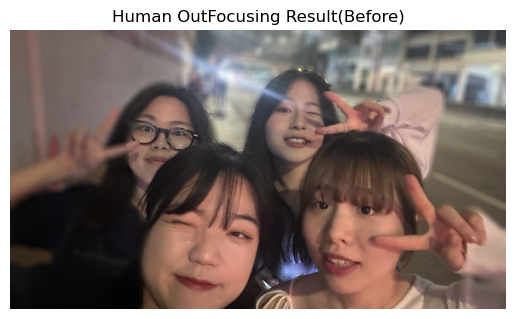

In [34]:
# Before
img = cv2.imread("319.jpg")

# 반환값 분리!
outfocus_img, mask_resized = apply_outfocus_to_human(img)

# 결과 시각화
plt.imshow(cv2.cvtColor(outfocus_img, cv2.COLOR_BGR2RGB))
plt.title("Human OutFocusing Result(Before)")
plt.axis("off")
plt.show()

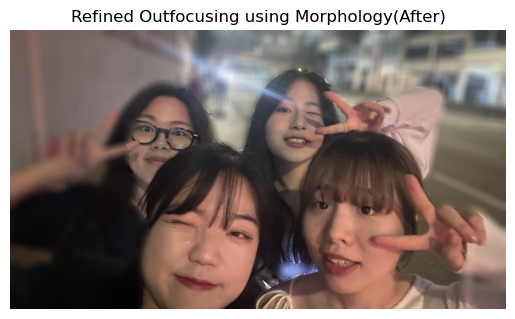

In [35]:
# After
img = cv2.imread("319.jpg")
outfocus_img = apply_outfocus_to_human_mor(img)

plt.imshow(cv2.cvtColor(outfocus_img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Refined Outfocusing using Morphology(After)")
plt.show()

- 사실 뭔가 뽀얗게 된 거 같은데 잘 모르겠어서 다른 사진으로 테스트를 해보겠습니다.

In [36]:
# 위와 동일한 함수인데, 고양이를 인식할 수 있도록 했습니다.

def apply_outfocus_to_cat_mor(image_bgr: np.ndarray) -> np.ndarray:
    transform = T.Compose([
        T.ToPILImage(),
        T.Resize((520, 520)),
        T.ToTensor(),
    ])

    # BGR → RGB 변환 후 Tensor로 변환
    img_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    input_tensor = transform(img_rgb).unsqueeze(0)

    # 모델 불러오기
    model = deeplabv3_resnet101(pretrained=True).eval()

    # 예측
    with torch.no_grad():
        output = model(input_tensor)["out"][0]
        prediction = output.argmax(0).byte().cpu().numpy()

    # 원본 크기 복원
    mask_resized = cv2.resize(prediction, (image_bgr.shape[1], image_bgr.shape[0]), interpolation=cv2.INTER_NEAREST)

    # 인물 클래스(15)만 선택
    person_mask = (mask_resized == 8).astype(np.uint8) * 255

    # 마스크 후처리
    kernel = getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))  # 커널 크기 조정 가능
    refined_mask = morphologyEx(person_mask, MORPH_OPEN, kernel)
    refined_mask = morphologyEx(refined_mask, MORPH_CLOSE, kernel)

    # 마스크 컬러 변환 및 반전
    mask_color = cv2.cvtColor(refined_mask, cv2.COLOR_GRAY2BGR)
    mask_inv = cv2.bitwise_not(mask_color)

    # 배경 블러
    blurred = cv2.blur(image_bgr, (25, 25))
    background = cv2.bitwise_and(blurred, mask_inv)

    # 인물 부분은 원본 유지
    result = np.where(mask_color == 255, image_bgr, background)

    return result

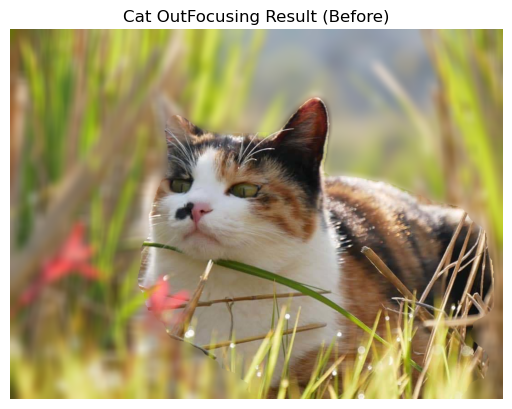

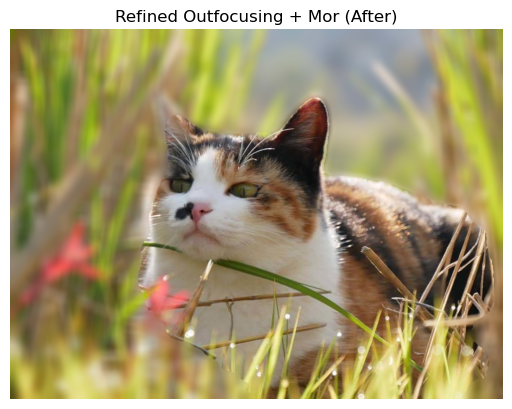

In [101]:
#Before
img = cv2.imread("hahaha_samsaek.jpeg")

outfocus_img = apply_outfocus_to_cat(img)

plt.imshow(cv2.cvtColor(outfocus_img, cv2.COLOR_BGR2RGB))
plt.title("Cat OutFocusing Result (Before)")
plt.axis("off")
plt.show()

#After
outfocus_img = apply_outfocus_to_cat_mor(img)

plt.imshow(cv2.cvtColor(outfocus_img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Refined Outfocusing + Mor (After)")
plt.show()

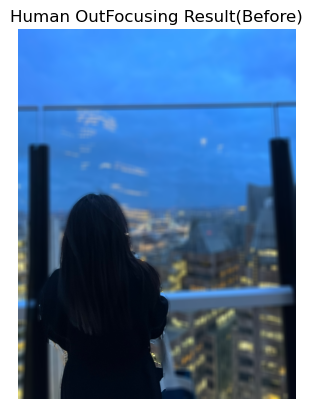

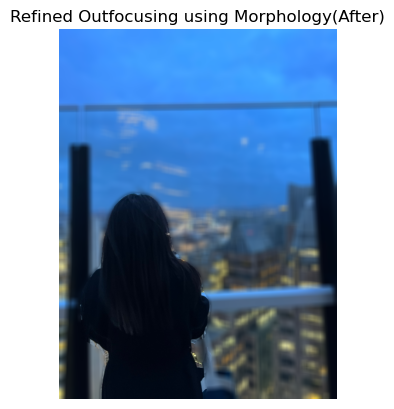

In [43]:
# Before
img = cv2.imread("프로필 사진.jpg")

outfocus_img, mask_resized = apply_outfocus_to_human(img)

# 결과 시각화
plt.imshow(cv2.cvtColor(outfocus_img, cv2.COLOR_BGR2RGB))
plt.title("Human OutFocusing Result(Before)")
plt.axis("off")
plt.show()


# After
outfocus_img = apply_outfocus_to_human_mor(img)

plt.imshow(cv2.cvtColor(outfocus_img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Refined Outfocusing using Morphology(After)")
plt.show()

## 7-2. Soft Mask 기반 아웃 포커싱
- armax로 딱 잘라서 마스크를 만들지 않고, 해당 클래스의 softmax 확률값을 활용해서 부드러운 아웃 포커싱이 가능합니다.
- 개인적으로 이게 제일 자연스럽지 않나.. 생각이 듭니다. (만족)

In [45]:
import cv2
import numpy as np
import torch
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet101
import matplotlib.pyplot as plt

- 원래는 ```prediction = output.argmax(0)```를 이용했는데, 이거는 가장 가능성이 높은 클래스 하나만 선택합니다.
- 그러므로 결과로 딱 잘린 이진 마스크가 나오게 됩니다. 이걸 사용하면 대상만 남기고 배경은 블러 처리를 합니다.
- 결국 경계가 거칠고 뚝 잘려서 인위적이게 되어서 자연스러운 흐림 표현이 어렵기 때문에 합성같아 보일 수 있습니다.

In [46]:
def apply_soft_outfocus(image_bgr: np.ndarray, target_class: int = 15) -> np.ndarray:
    # 전처리
    transform = T.Compose([
        T.ToPILImage(),
        T.Resize((520, 520)),
        T.ToTensor(),
    ])

    img_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    input_tensor = transform(img_rgb).unsqueeze(0)

    # 모델 불러오기
    model = deeplabv3_resnet101(pretrained=True).eval()

    with torch.no_grad():
        output = model(input_tensor)["out"][0]  # shape: (21, 520, 520)
        probs = torch.softmax(output, dim=0)[target_class]  # target_class의 softmax 확률

    # 확률을 numpy로 변환하고 원본 크기로 리사이즈
    prob_mask = probs.cpu().numpy()
    prob_mask_resized = cv2.resize(prob_mask, (image_bgr.shape[1], image_bgr.shape[0]))

    # 배경 블러
    blurred = cv2.blur(image_bgr, (25, 25))

    # 알파 블렌딩 : 3채널 alpha mask 생성
    alpha = np.expand_dims(prob_mask_resized, axis=2)  # shape: (H, W, 1)
    result = (image_bgr * alpha + blurred * (1 - alpha)).astype(np.uint8)

    return result

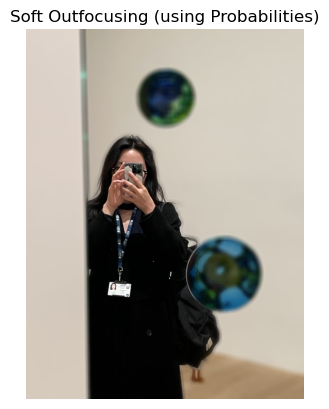

In [47]:
img = cv2.imread("Tate_Modern.jpg")  
out_img = apply_soft_outfocus(img)

plt.imshow(cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Soft Outfocusing (using Probabilities)")
plt.show()

- 하지만 Soft Mask는 Softmax 확률을 가져오는데, ```probs = torch.softmax(output, dim=0)[target_class] ```
- 각 픽셀이 해당 클래스를 가질 확률(0.0 ~ 0.1)을 가져오기 때문에 이진 분류 말고 세분화가 가능합니다.
    
- 저 값을 블렌딩 마스크로 활용하고, Alpha Blending을 이용하여 픽셀 단위로 혼합합니다.
- ```result_pixel = foreground_pixel * alpha + background_pixel * (1 - alpha)``` : 1에 가까울 수록 선명 (0은 반대)
- 그래서 확률이 높으면 원본처럼 보이고, 낮으면 흐리게 블렌딩 되며, 경계는 선명했다가 흐려지는 효과가 생깁니다.
    
- 이 부분에서 실제 카메라 렌즈의 심도 변화를 알아볼 수 있습니다.